In [2]:
# pip install lightgbm

In [3]:
import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/data-postuplenie-with-clusters/data_postuplenie_with_clusters.csv


In [5]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')  
else:
    device = torch.device('cpu')  
    print("GPU не доступен, обучение будет выполняться на CPU.")

GPU не доступен, обучение будет выполняться на CPU.


In [6]:
df = pd.read_csv('/kaggle/input/data-postuplenie-with-clusters/data_postuplenie_with_clusters.csv')

In [7]:
df

,date,visitDuration,isNewUser,daysSinceFirstVisit,endURL,previousVisitDate,ageInterval,regionArea,userVisits,pageviews,avgVisitDurationSeconds,pageDepth,bounceRate,faculty_info,cluster
0,2020-06-25,10,New users,0,http://nosu.ru/abiturientam/postuplenie/,0000-00-00,Age 45-54,Republic of Dagestan,1,2.0,10.0,2.0,0.0,postuplenie,7
1,2020-06-25,20,New users,0,http://nosu.ru/abiturientam/postuplenie/,0000-00-00,Age 35‑44,Krasnoyarsk Krai,1,2.0,20.0,2.0,0.0,postuplenie,1
2,2020-06-25,30,New users,0,http://nosu.ru/abiturientam/postuplenie/,0000-00-00,Age 18‑24,Republic of North Ossetia — Alania,1,2.0,30.0,2.0,0.0,postuplenie,7
3,2020-06-25,283,Returning users,0,http://nosu.ru/abiturientam/postuplenie/dokume...,2020-06-25,Age 18‑24,Republic of North Ossetia — Alania,2,9.0,283.0,9.0,0.0,postuplenie,17
4,2020-06-25,98,New users,0,http://nosu.ru/abiturientam/postuplenie/bakala...,0000-00-00,Not specified,Not specified,1,4.0,98.0,4.0,0.0,postuplenie,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366852,2024-03-01,47,Returning users,10,https://nosu.ru/abiturientam/postuplenie/,2024-03-01,Age 25‑34,Republic of North Ossetia — Alania,3,4.0,47.0,4.0,0.0,postuplenie,0
366853,2024-03-01,55,Returning users,27,https://nosu.ru/abiturientam/postuplenie/,2024-02-02,Not specified,Republic of North Ossetia — Alania,2,1.0,55.0,1.0,0.0,postuplenie,5
366854,2024-03-01,143,New users,0,https://nosu.ru/abiturientam/postuplenie/,0000-00-00,Not specified,Republic of North Ossetia — Alania,1,7.0,143.0,7.0,0.0,postuplenie,7
366855,2024-03-01,28,New users,0,https://nosu.ru/abiturientam/postuplenie/,0000-00-00,Not specified,Not specified,1,2.0,28.0,2.0,0.0,postuplenie,1


In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['previousVisitDate'] = pd.to_datetime(df['previousVisitDate'], errors='coerce')

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [9]:
categorical_cols = ['isNewUser', 'ageInterval', 'regionArea', 'faculty_info']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [10]:
df = df.drop(columns=['endURL','previousVisitDate', 'faculty_info', 'date' ], axis=1)

In [11]:
scaler = StandardScaler()

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

if 'cluster' in numeric_cols:
    numeric_cols = numeric_cols.drop('cluster')

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [12]:
df

,visitDuration,isNewUser,daysSinceFirstVisit,ageInterval,regionArea,userVisits,pageviews,avgVisitDurationSeconds,pageDepth,bounceRate,cluster
0,-0.469675,-1.501269,-0.393792,-0.110910,0.248529,-0.346474,-0.358669,-0.469675,-0.357623,-0.35886,7
1,-0.453571,-1.501269,-0.393792,-0.548321,-1.438927,-0.346474,-0.358669,-0.453571,-0.357623,-0.35886,1
2,-0.437466,-1.501269,-0.393792,-1.423144,0.403953,-0.346474,-0.358669,-0.437466,-0.357623,-0.35886,7
3,-0.030029,0.666103,-0.393792,-1.423144,0.403953,-0.329355,1.301208,-0.030029,1.301971,-0.35886,17
4,-0.327958,-1.501269,-0.393792,0.763913,-0.461979,-0.346474,0.115581,-0.327958,0.116547,-0.35886,1
...,...,...,...,...,...,...,...,...,...,...,...
366852,-0.410089,0.666103,-0.304017,-0.985733,0.403953,-0.312235,0.115581,-0.410089,0.116547,-0.35886,0
366853,-0.397206,0.666103,-0.151400,0.763913,0.403953,-0.329355,-0.595795,-0.397206,-0.594708,-0.35886,5
366854,-0.255488,-1.501269,-0.393792,0.763913,0.403953,-0.346474,0.826957,-0.255488,0.827802,-0.35886,7
366855,-0.440687,-1.501269,-0.393792,0.763913,-0.461979,-0.346474,-0.358669,-0.440687,-0.357623,-0.35886,1


In [13]:
X, y = df.drop(columns='cluster', axis=1), df['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(f'Размер X_train: {X_train.shape}')
print('-'*30)
print(f'Размер X_test: {X_test.shape}')
print('-'*30)
print(f'Размер y_train: {y_train.shape}')
print('-'*30)
print(f'Размер y_test: {y_test.shape}')

Размер X_train: (293485, 10)
------------------------------
Размер X_test: (73372, 10)
------------------------------
Размер y_train: (293485,)
------------------------------
Размер y_test: (73372,)


In [15]:
print(X_train.dtypes)
print(y_train.dtypes)

visitDuration              float64
isNewUser                  float64
daysSinceFirstVisit        float64
ageInterval                float64
regionArea                 float64
userVisits                 float64
pageviews                  float64
avgVisitDurationSeconds    float64
pageDepth                  float64
bounceRate                 float64
dtype: object
int64


In [16]:
model = xgb.XGBClassifier(objective='multi:softmax', num_class=18, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Точность модели: {accuracy * 100:.2f}%")

Точность модели: 99.33%


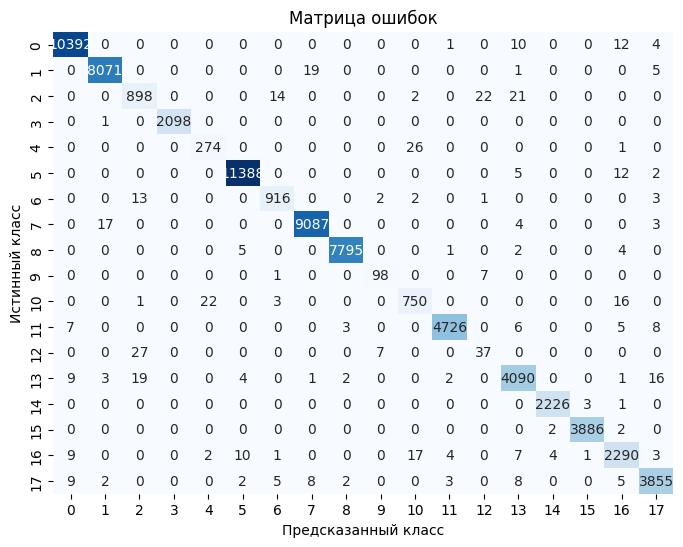

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок")
plt.show()

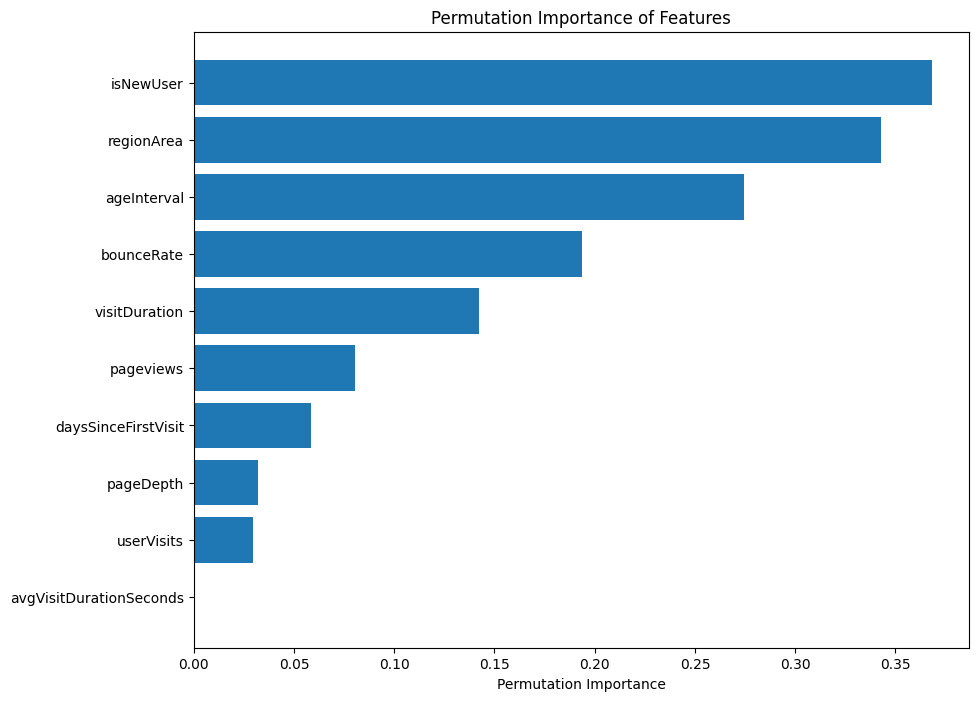

In [18]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.show()

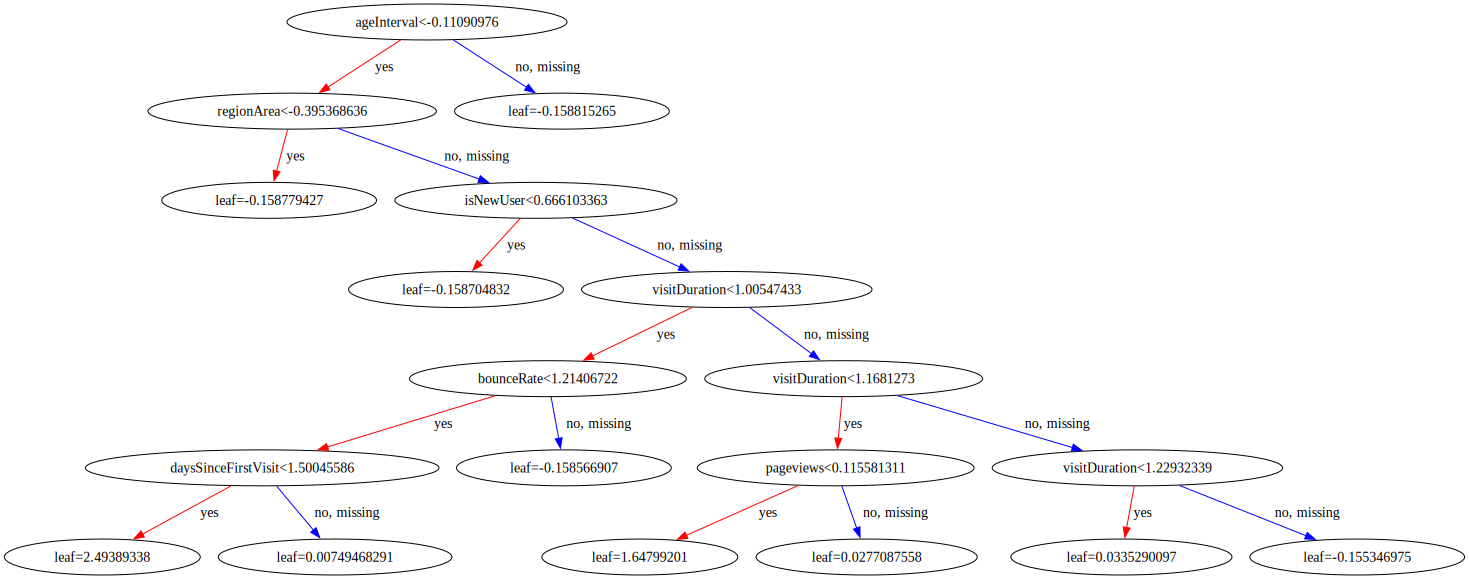

In [19]:
xgb.to_graphviz(model, num_trees=0, fname="tree.pdf")

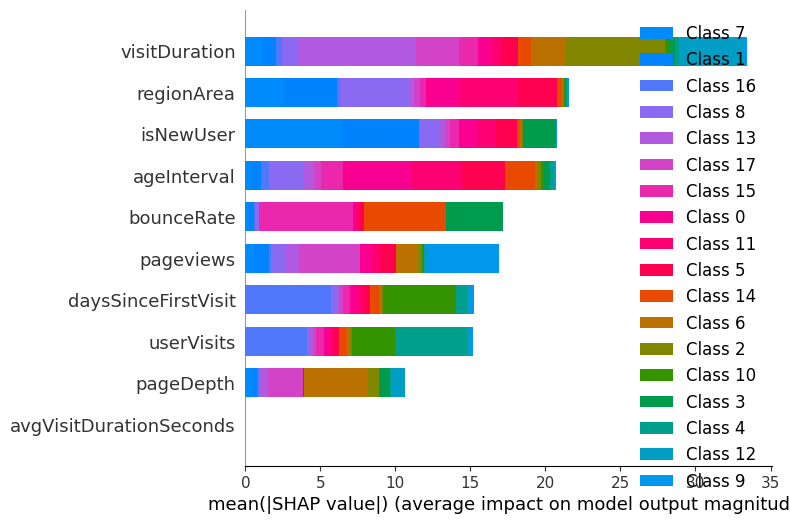

<Figure size 640x480 with 0 Axes>

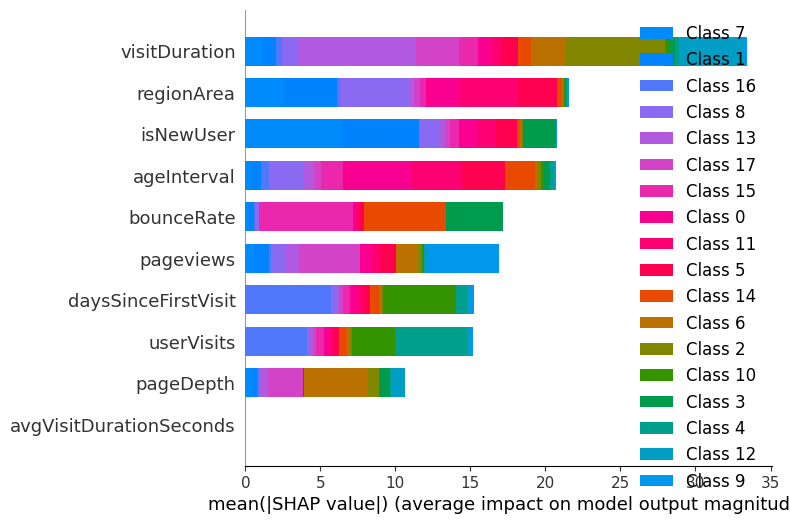

<Figure size 640x480 with 0 Axes>

In [21]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(20, 7))  
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.savefig("shap_summary_bar.png") 

plt.figure(figsize=(20, 7))  
shap.summary_plot(shap_values, X_test)
plt.savefig("shap_summary_all.png") 
plt.show()  